# Capstone Project: Fandango Movie Ratings Analysis

## Part 1: Data Acquisition and Initial Exploration

The goal of this project is to analyze the Fandango movie rating system and compare its scores to other popular review sites like Rotten Tomatoes, Metacritic, and IMDB. We aim to investigate the common claim that Fandango systematically inflates its displayed "Stars" rating.

The first step is to import the necessary libraries for data manipulation, visualization, and statistical analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We will load the two provided CSV files: `fandango_scrape.csv` (scraped data from Fandango) and `all_sites_scores.csv` (aggregated scores from other sites). We start by loading the Fandango data and examining its structure using the `.info()` method.

In [2]:
fandango = pd.read_csv("fandango_scrape.csv")

In [3]:
fandango.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FILM    510 non-null    object 
 1   STARS   510 non-null    float64
 2   RATING  510 non-null    float64
 3   VOTES   510 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 16.1+ KB


Let's view the first few rows of the data and generate descriptive statistics for the numerical columns to understand the range and distribution of the values.

Key columns to observe:
* **STARS**: The number of stars **displayed** on the Fandango website (out of 5.0).
* **RATING**: The **actual** user rating recorded by Fandango (out of 5.0, a more precise value).

In [4]:
fandango.head()

,FILM,STARS,RATING,VOTES
0,Fifty Shades of Grey (2015),4.0,3.9,34846
1,Jurassic World (2015),4.5,4.5,34390
2,American Sniper (2015),5.0,4.8,34085
3,Furious 7 (2015),5.0,4.8,33538
4,Inside Out (2015),4.5,4.5,15749


In [5]:
fandango.describe()

,STARS,RATING,VOTES
count,510.000000,510.000000,510.000000
mean,3.532353,3.351765,1134.364706
std,1.585616,1.512628,3809.952176
min,0.000000,0.000000,0.000000
25%,3.500000,3.025000,2.000000
50%,4.000000,3.800000,17.500000
75%,4.500000,4.300000,183.500000
max,5.000000,5.000000,34846.000000


## Part 2: Fandango Data Cleaning and Discrepancy Analysis

We'll start by checking the relationship between the actual Fandango rating (`RATING`) and the number of votes a film received (`VOTES`). A positive correlation is expected, as more popular movies often receive higher scores.

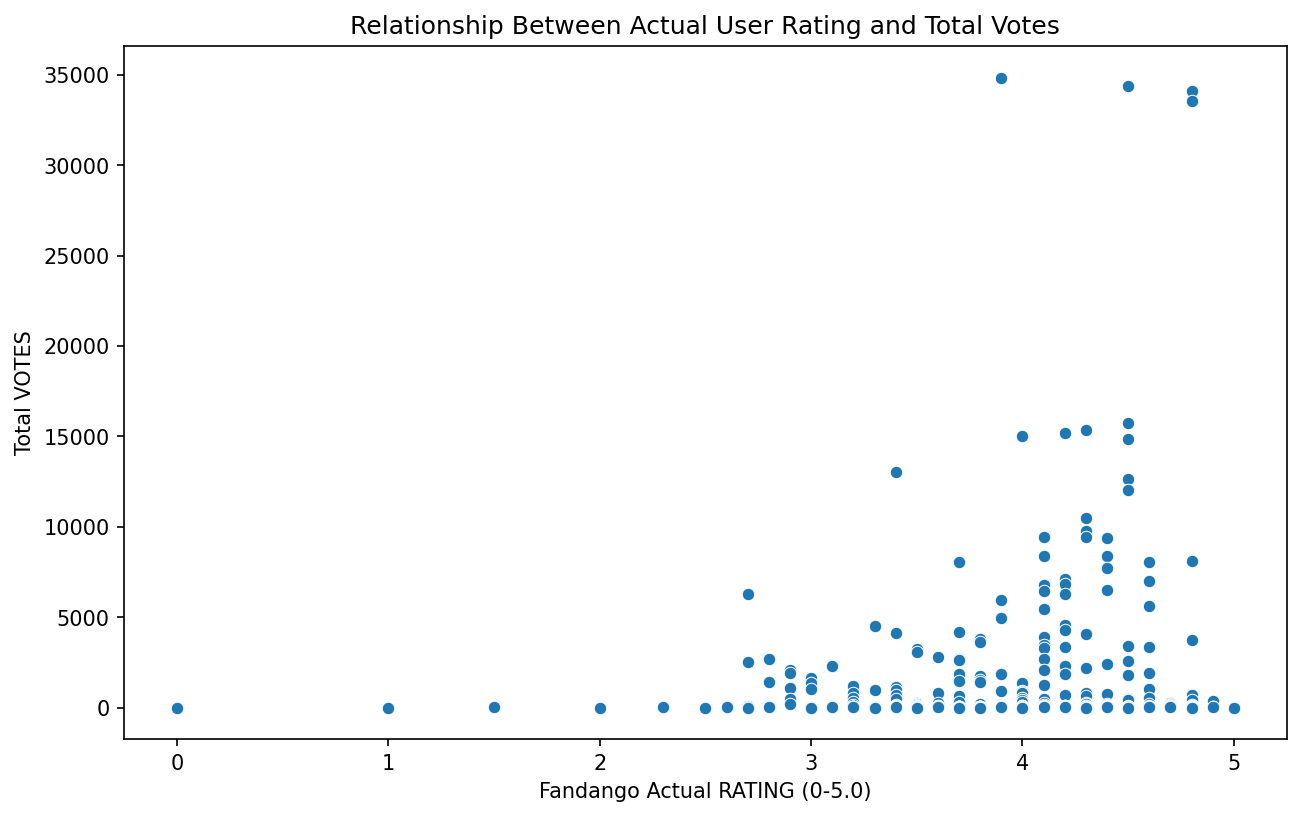

In [6]:
plt.figure(figsize=(10,6), dpi=150)
sns.scatterplot(data=fandango, x='RATING', y='VOTES')
plt.title('Relationship Between Actual User Rating and Total Votes')
plt.xlabel('Fandango Actual RATING (0-5.0)')
plt.ylabel('Total VOTES')
plt.show()

To quantify the relationships, we'll generate a correlation matrix for the numerical columns. The correlation between `STARS` and `RATING` should be near perfect, while the correlation between ratings and `VOTES` shows how much popularity relates to score.

In [7]:
fandango.corr(numeric_only=True)

,STARS,RATING,VOTES
STARS,1.000000,0.994870,0.165774
RATING,0.994870,1.000000,0.165147
VOTES,0.165774,0.165147,1.000000


To analyze the data by release year, we need to extract the year from the `FILM` title. We will create a new column called `YEAR` and then check the distribution of films by year.

In [8]:
fandango['YEAR'] = fandango['FILM'].apply(lambda title: title.split('(')[-1].replace(')',''))

In [9]:
fandango['YEAR'].value_counts()

YEAR
2015    478
2014     23
1         7
2016      1
1964      1
Name: count, dtype: int64

The value counts revealed a few entries with an incorrect year value ('1'). We must identify and remove these films to maintain data integrity for any year-based analysis.

In [10]:
# Inspecting films with the incorrect year value
fandango[fandango['YEAR']=='1']

,FILM,STARS,RATING,VOTES,YEAR
393,We Come as Friends (1),4.0,4.0,2,1
422,The Mend (1),4.0,4.0,1,1
464,La dame en or (1),0.0,0.0,0,1
479,New Movie (1),0.0,0.0,0,1
486,Prison 101 (1),0.0,0.0,0,1
503,Traque (1),0.0,0.0,0,1
509,Zarafa (1),0.0,0.0,0,1


In [11]:
# Filtering out the films with the invalid year
fandango = fandango[fandango['YEAR']!='1']

In [12]:
# Verifying the removal
fandango['YEAR'].value_counts()

YEAR
2015    478
2014     23
2016      1
1964      1
Name: count, dtype: int64

The final `fandango` DataFrame is ready. Let's confirm the total count and visualize the distribution of release years in the cleaned dataset.

In [13]:
len(fandango)

503

/tmp/ipykernel_4712/687466121.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=fandango, x='YEAR', palette='viridis')


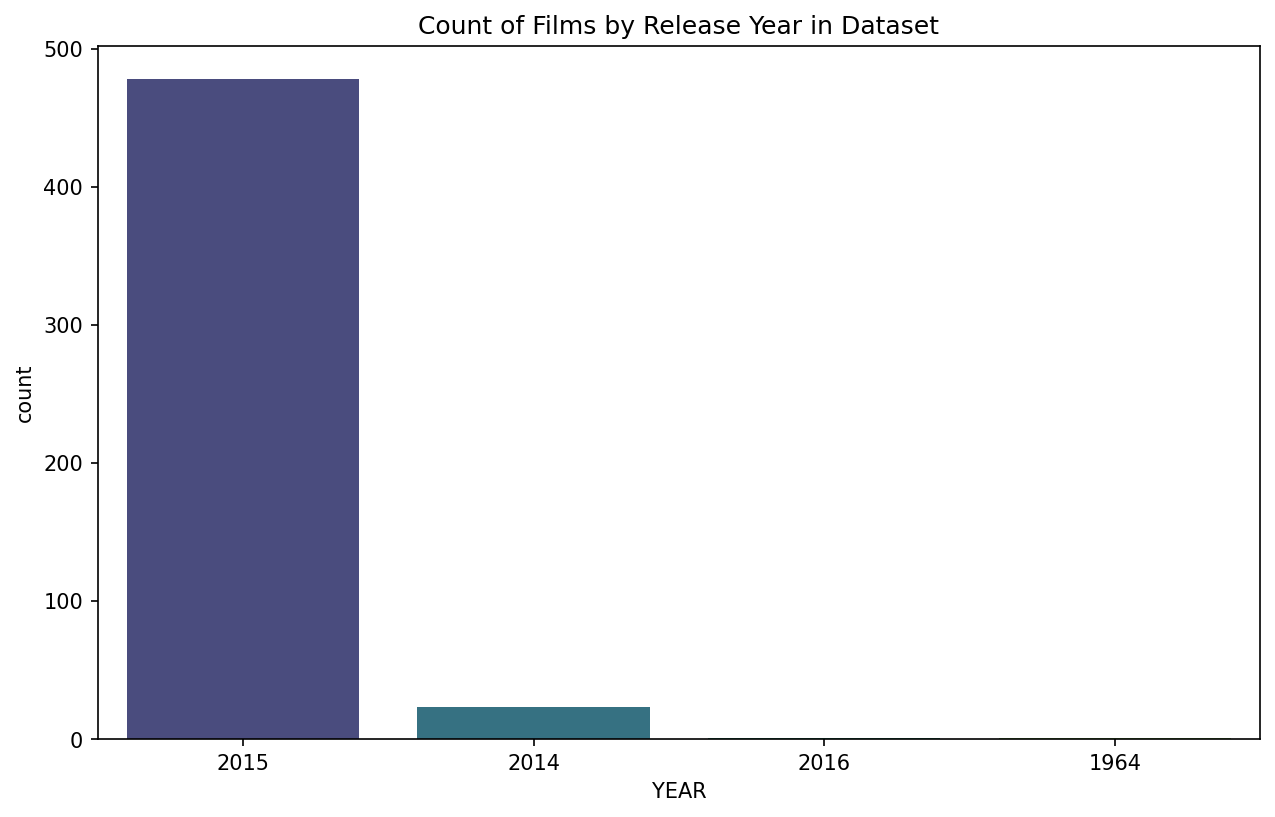

In [14]:
plt.figure(figsize=(10,6), dpi=150)
sns.countplot(data=fandango, x='YEAR', palette='viridis')
plt.title('Count of Films by Release Year in Dataset')
plt.show()

For the analysis of rating discrepancy, we only want to look at movies that have actually received user votes. We'll filter out any film with 0 votes, as these entries likely represent scraped films that had not yet been rated.

In [15]:
# Identify the most-voted film for context
fandango.nlargest(1,'VOTES')

,FILM,STARS,RATING,VOTES,YEAR
0,Fifty Shades of Grey (2015),4.0,3.9,34846,2015


In [16]:
# Filter the DataFrame to include only films with > 0 votes
fan_films = fandango[fandango['VOTES']>0]

In [17]:
# Check the number of films remaining
len(fan_films)

435

The core of the investigation is the difference between the **displayed STARS** (what the user sees) and the **actual RATING** (the true fractional score). We create a new feature, `STARS_DIFF`, to quantify this inflation.

In [18]:
# Calculate the difference and round it to two decimal places
fan_films['STARS_DIFF'] = fan_films['STARS'] - fan_films['RATING']
fan_films['STARS_DIFF'] = fan_films['STARS_DIFF'].round(2)

/tmp/ipykernel_4712/3869022208.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fan_films['STARS_DIFF'] = fan_films['STARS'] - fan_films['RATING']
/tmp/ipykernel_4712/3869022208.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fan_films['STARS_DIFF'] = fan_films['STARS_DIFF'].round(2)


In [19]:
fan_films.head()

,FILM,STARS,RATING,VOTES,YEAR,STARS_DIFF
0,Fifty Shades of Grey (2015),4.0,3.9,34846,2015,0.1
1,Jurassic World (2015),4.5,4.5,34390,2015,0.0
2,American Sniper (2015),5.0,4.8,34085,2015,0.2
3,Furious 7 (2015),5.0,4.8,33538,2015,0.2
4,Inside Out (2015),4.5,4.5,15749,2015,0.0


In [20]:
# Count the occurrences of each difference value
fan_films['STARS_DIFF'].value_counts()

STARS_DIFF
0.0    107
0.2     82
0.3     72
0.4     70
0.1     66
0.5     37
1.0      1
Name: count, dtype: int64

/tmp/ipykernel_4712/3724389191.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=fan_films, x='STARS_DIFF', palette='magma')


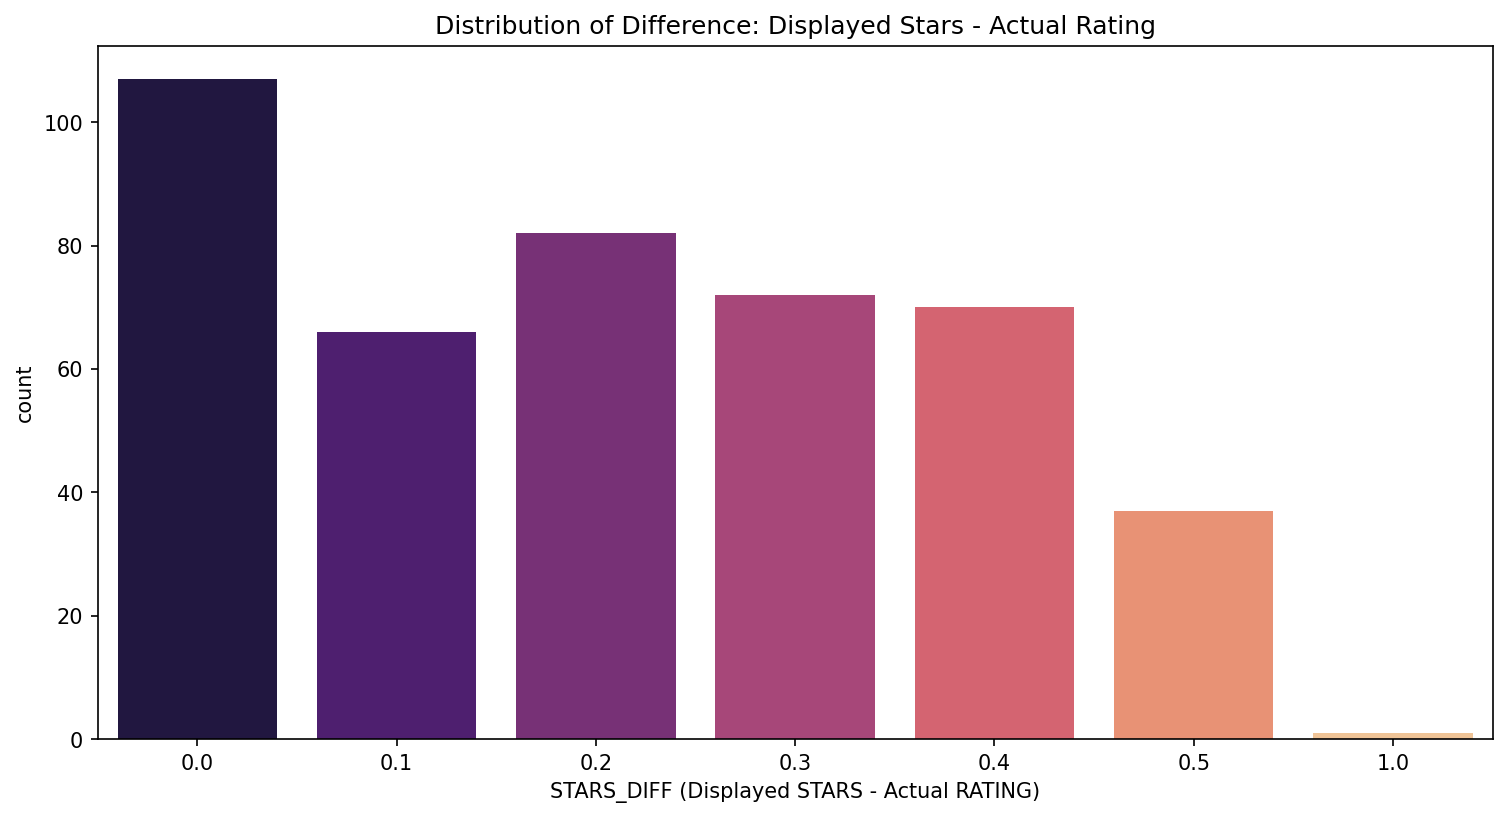

In [21]:
plt.figure(figsize=(12,6), dpi=150)
sns.countplot(data=fan_films, x='STARS_DIFF', palette='magma')
plt.title('Distribution of Difference: Displayed Stars - Actual Rating')
plt.xlabel('STARS_DIFF (Displayed STARS - Actual RATING)')
plt.show()

The count plot confirmed a systematic positive difference. Now, we calculate the average absolute difference and visualize the overall distributions of `RATING` and `STARS` using a Kernel Density Estimate (KDE) plot.

In [22]:
mean_absolute_difference = (fan_films['STARS_DIFF'].apply(abs)).mean()
print(f"Mean Absolute Difference (Displayed STARS - Actual RATING): {mean_absolute_difference:.2f}")

Mean Absolute Difference (Displayed STARS - Actual RATING): 0.21


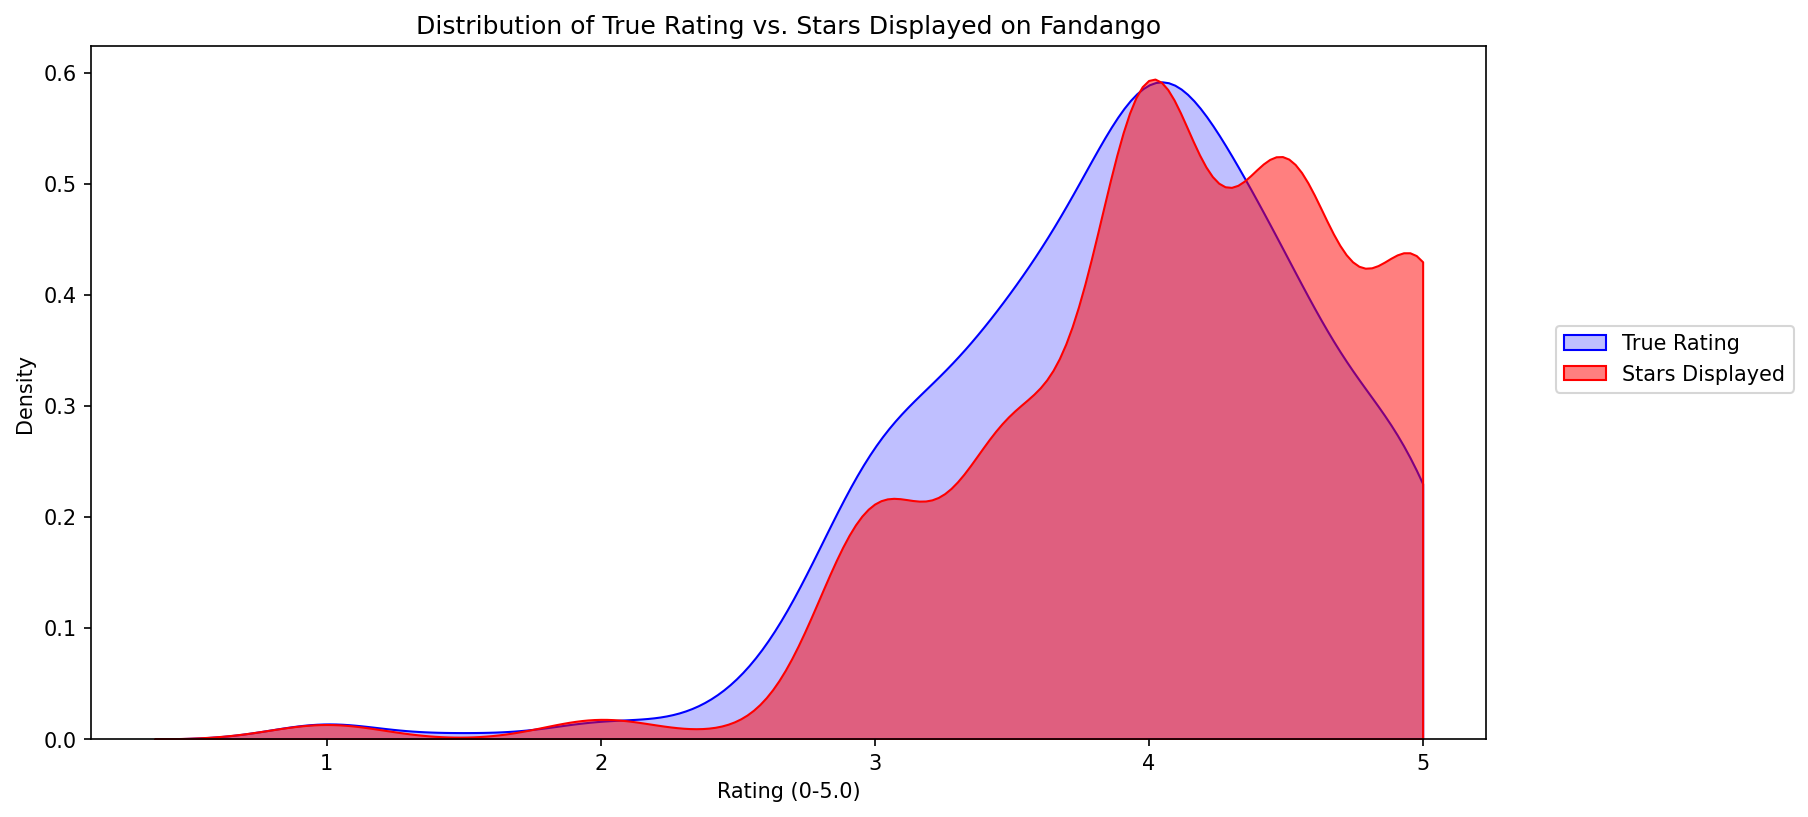

In [23]:
plt.figure(figsize=(12,6),dpi=150)
sns.kdeplot(data=fan_films, x='RATING', clip=[0,5], fill=True, label='True Rating', color='blue')
sns.kdeplot(data=fan_films, x='STARS', clip=[0,5], fill=True, label='Stars Displayed', color='red', alpha=0.5)
plt.legend(loc=(1.05, 0.5))
plt.title('Distribution of True Rating vs. Stars Displayed on Fandango')
plt.xlabel('Rating (0-5.0)')
plt.show()

## Part 3: Comparing Fandango Ratings with Other Sites

We now load the aggregated scores from other major movie review aggregators: Rotten Tomatoes (RT), Metacritic (MC), and IMDB.

In [24]:
all_sites = pd.read_csv("all_site_scores.csv")

In [25]:
all_sites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FILM                        146 non-null    object 
 1   RottenTomatoes              146 non-null    int64  
 2   RottenTomatoes_User         146 non-null    int64  
 3   Metacritic                  146 non-null    int64  
 4   Metacritic_User             146 non-null    float64
 5   IMDB                        146 non-null    float64
 6   Fandango_Stars              146 non-null    float64
 7   Fandango_Ratingvalue        146 non-null    float64
 8   RT_norm                     146 non-null    float64
 9   RT_user_norm                146 non-null    float64
 10  Metacritic_norm             146 non-null    float64
 11  Metacritic_user_nom         146 non-null    float64
 12  IMDB_norm                   146 non-null    float64
 13  RT_norm_round               146 non

In [26]:
all_sites.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,...,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,...,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


Before merging, we briefly check the difference between Rotten Tomatoes Critic Score and User Score to see if non-systematic disagreement exists on other platforms.

In [27]:
all_sites['RottenTomatoes_Diff'] = all_sites['RottenTomatoes'] - all_sites['RottenTomatoes_User']

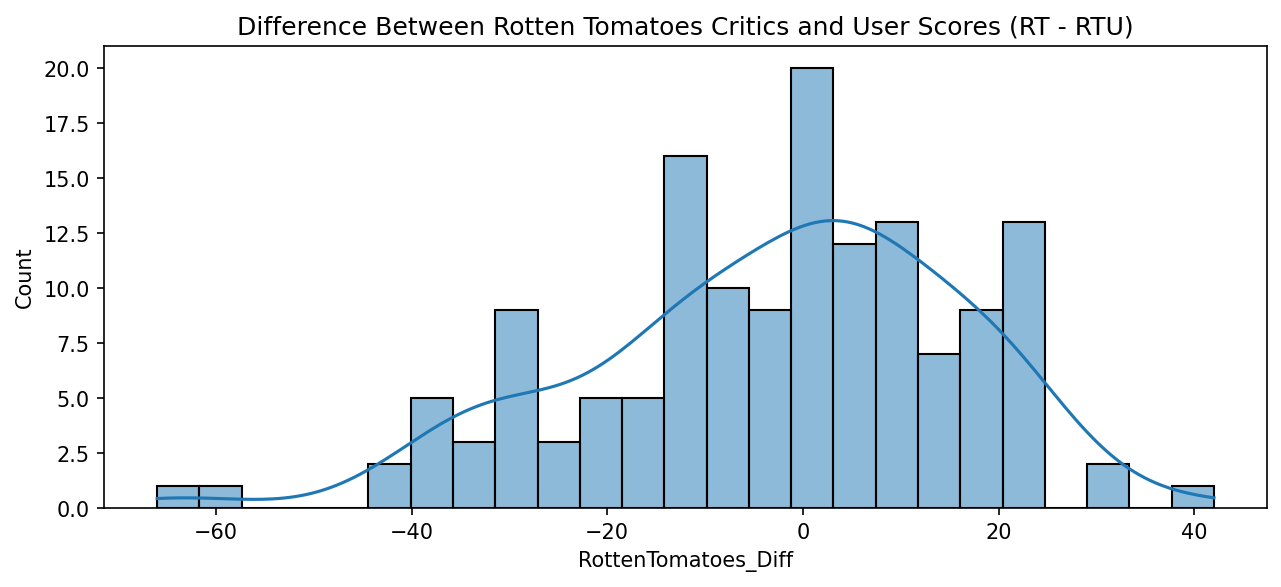

In [28]:
plt.figure(figsize=(10,4), dpi=150)
sns.histplot(data=all_sites, x='RottenTomatoes_Diff', bins=25, kde=True)
plt.title('Difference Between Rotten Tomatoes Critics and User Scores (RT - RTU)')
plt.show()

In [29]:
mean_rt_abs_diff = all_sites['RottenTomatoes_Diff'].apply(abs).mean()
print(f"Mean Absolute Difference (RT - RTU): {mean_rt_abs_diff:.2f}")

Mean Absolute Difference (RT - RTU): 15.10


In [30]:
all_sites.nlargest(5, 'RottenTomatoes_Diff')

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference,RottenTomatoes_Diff
69,Mr. Turner (2014),98,56,94,6.6,6.9,3.5,3.2,4.90,2.80,...,5.0,3.0,4.5,3.5,3.5,98,13296,290,0.3,42
112,It Follows (2015),96,65,83,7.5,6.9,3.0,2.9,4.80,3.25,...,5.0,3.5,4.0,4.0,3.5,551,64656,2097,0.1,31
115,While We're Young (2015),83,52,76,6.7,6.4,3.0,2.9,4.15,2.60,...,4.0,2.5,4.0,3.5,3.0,65,17647,449,0.1,31
37,Welcome to Me (2015),71,47,67,6.9,5.9,4.0,3.6,3.55,2.35,...,3.5,2.5,3.5,3.5,3.0,33,8301,56,0.4,24
40,I'll See You In My Dreams (2015),94,70,75,6.9,6.9,4.0,3.6,4.70,3.50,...,4.5,3.5,4.0,3.5,3.5,14,1151,281,0.4,24


We merge the Fandango data (`fandango`) with the external scores (`all_sites`) on the common column `FILM`. We use an inner merge to keep only the movies present in both datasets.

In [31]:
all = pd.merge(fandango, all_sites, on='FILM', how='inner')

In [32]:
all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FILM                        145 non-null    object 
 1   STARS                       145 non-null    float64
 2   RATING                      145 non-null    float64
 3   VOTES                       145 non-null    int64  
 4   YEAR                        145 non-null    object 
 5   RottenTomatoes              145 non-null    int64  
 6   RottenTomatoes_User         145 non-null    int64  
 7   Metacritic                  145 non-null    int64  
 8   Metacritic_User             145 non-null    float64
 9   IMDB                        145 non-null    float64
 10  Fandango_Stars              145 non-null    float64
 11  Fandango_Ratingvalue        145 non-null    float64
 12  RT_norm                     145 non-null    float64
 13  RT_user_norm                145 non

In [33]:
all.head()

,FILM,STARS,RATING,VOTES,YEAR,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,...,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference,RottenTomatoes_Diff
0,Fifty Shades of Grey (2015),4.0,3.9,34846,2015,25,42,46,3.2,4.2,...,1.5,2.0,2.5,1.5,2.0,778,179506,34846,0.1,-17
1,Jurassic World (2015),4.5,4.5,34390,2015,71,81,59,7.0,7.3,...,3.5,4.0,3.0,3.5,3.5,1281,241807,34390,0.0,-10
2,American Sniper (2015),5.0,4.8,34085,2015,72,85,72,6.6,7.4,...,3.5,4.5,3.5,3.5,3.5,850,251856,34085,0.2,-13
3,Furious 7 (2015),5.0,4.8,33538,2015,81,84,67,6.8,7.4,...,4.0,4.0,3.5,3.5,3.5,764,207211,33538,0.2,-3
4,Inside Out (2015),4.5,4.5,15749,2015,98,90,94,8.9,8.6,...,5.0,4.5,4.5,4.5,4.5,807,96252,15749,0.0,8


### Data Normalization

**CRUCIAL CORRECTION:** The scores from various sites are on different scales (e.g., Fandango is 0-5, Rotten Tomatoes is 0-100, IMDB is 0-10). To perform a valid comparison, we **must** normalize all scores to a common 0-5 scale.

* Scores out of 100 are divided by 20.
* Scores out of 10 are divided by 2.

In [34]:
# Normalizing all scores to a 0-5 scale and rounding to 1 decimal place
all['RT_Norm'] = round(all['RottenTomatoes'] / 20, 1)    # RT is out of 100
all['RTU_Norm'] = round(all['RottenTomatoes_User'] / 20, 1) # RT User is out of 100
all['MC_Norm'] = round(all['Metacritic'] / 20, 1)         # Metacritic is out of 100
all['MCU_Norm'] = round(all['Metacritic_User'] / 2, 1)     # Metacritic User is out of 10
all['IMDB_Norm'] = round(all['IMDB'] / 2, 1)              # IMDB is out of 10

# Display the new normalized columns alongside the originals
all[['FILM', 'RATING', 'STARS', 'RT_Norm', 'RTU_Norm', 'MC_Norm', 'MCU_Norm', 'IMDB_Norm']].head()

,FILM,RATING,STARS,RT_Norm,RTU_Norm,MC_Norm,MCU_Norm,IMDB_Norm
0,Fifty Shades of Grey (2015),3.9,4.0,1.2,2.1,2.3,1.6,2.1
1,Jurassic World (2015),4.5,4.5,3.6,4.0,3.0,3.5,3.6
2,American Sniper (2015),4.8,5.0,3.6,4.2,3.6,3.3,3.7
3,Furious 7 (2015),4.8,5.0,4.0,4.2,3.4,3.4,3.7
4,Inside Out (2015),4.5,4.5,4.9,4.5,4.7,4.4,4.3


With the normalized data, we can now safely compare the Fandango Actual RATING (`RATING`) with other scores, starting with the Normalized Rotten Tomatoes Critic Score (`RT_Norm`).

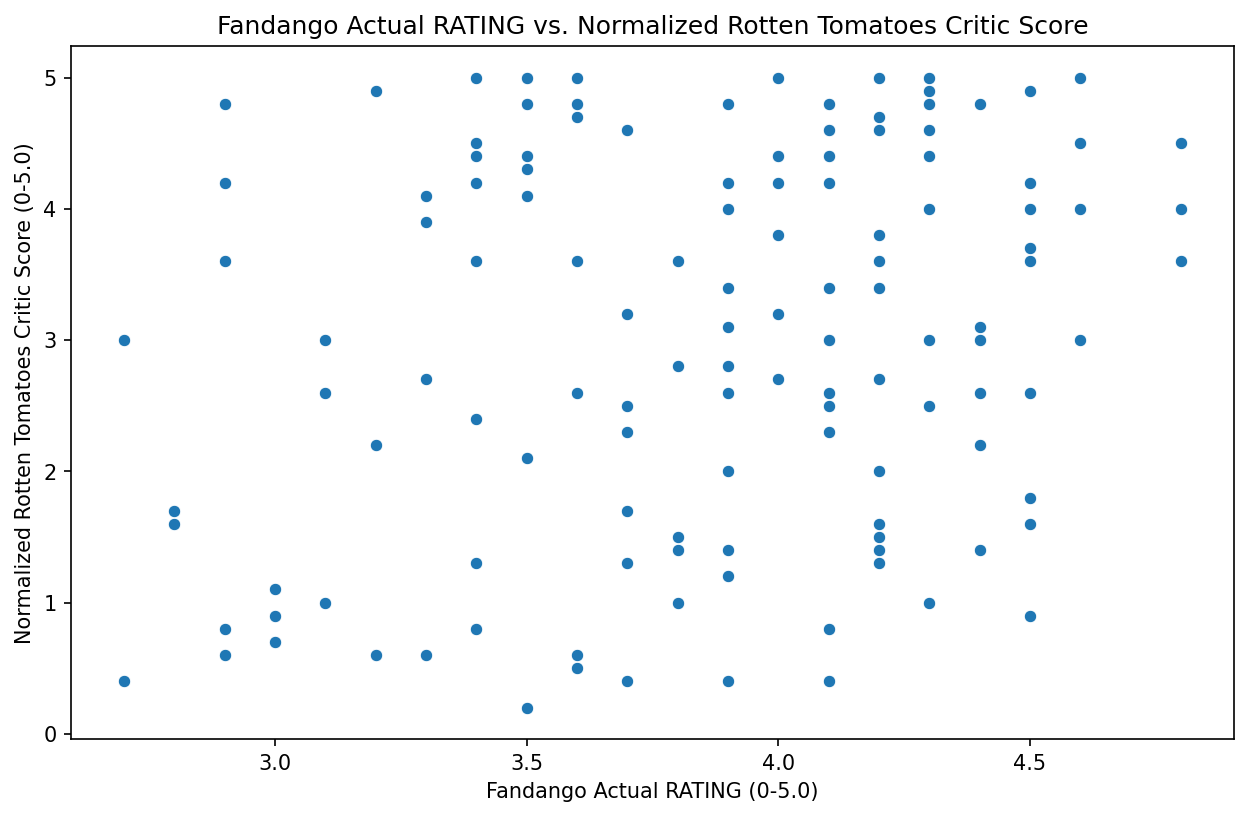

In [35]:
plt.figure(figsize=(10,6), dpi=150)
sns.scatterplot(data=all, x='RATING', y='RT_Norm')
plt.title('Fandango Actual RATING vs. Normalized Rotten Tomatoes Critic Score')
plt.xlabel('Fandango Actual RATING (0-5.0)')
plt.ylabel('Normalized Rotten Tomatoes Critic Score (0-5.0)')
plt.show()

To quantify the bias, we will calculate the mean score for all normalized ratings. This will show which platform, on average, gives the highest or lowest scores.

In [36]:
avg_ratings = all[['STARS', 'RATING', 'RT_Norm', 'RTU_Norm', 'MC_Norm', 'MCU_Norm', 'IMDB_Norm']].mean().sort_values(ascending=False)
print("Average Ratings Across All Sites (0-5 Scale):\n")
print(avg_ratings)

Average Ratings Across All Sites (0-5 Scale):

STARS        4.086207
RATING       3.841379
IMDB_Norm    3.369655
MCU_Norm     3.253793
RTU_Norm     3.180690
RT_Norm      3.033103
MC_Norm      2.942759
dtype: float64


/tmp/ipykernel_4712/2791981363.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_ratings.index, y=avg_ratings.values, palette='coolwarm')


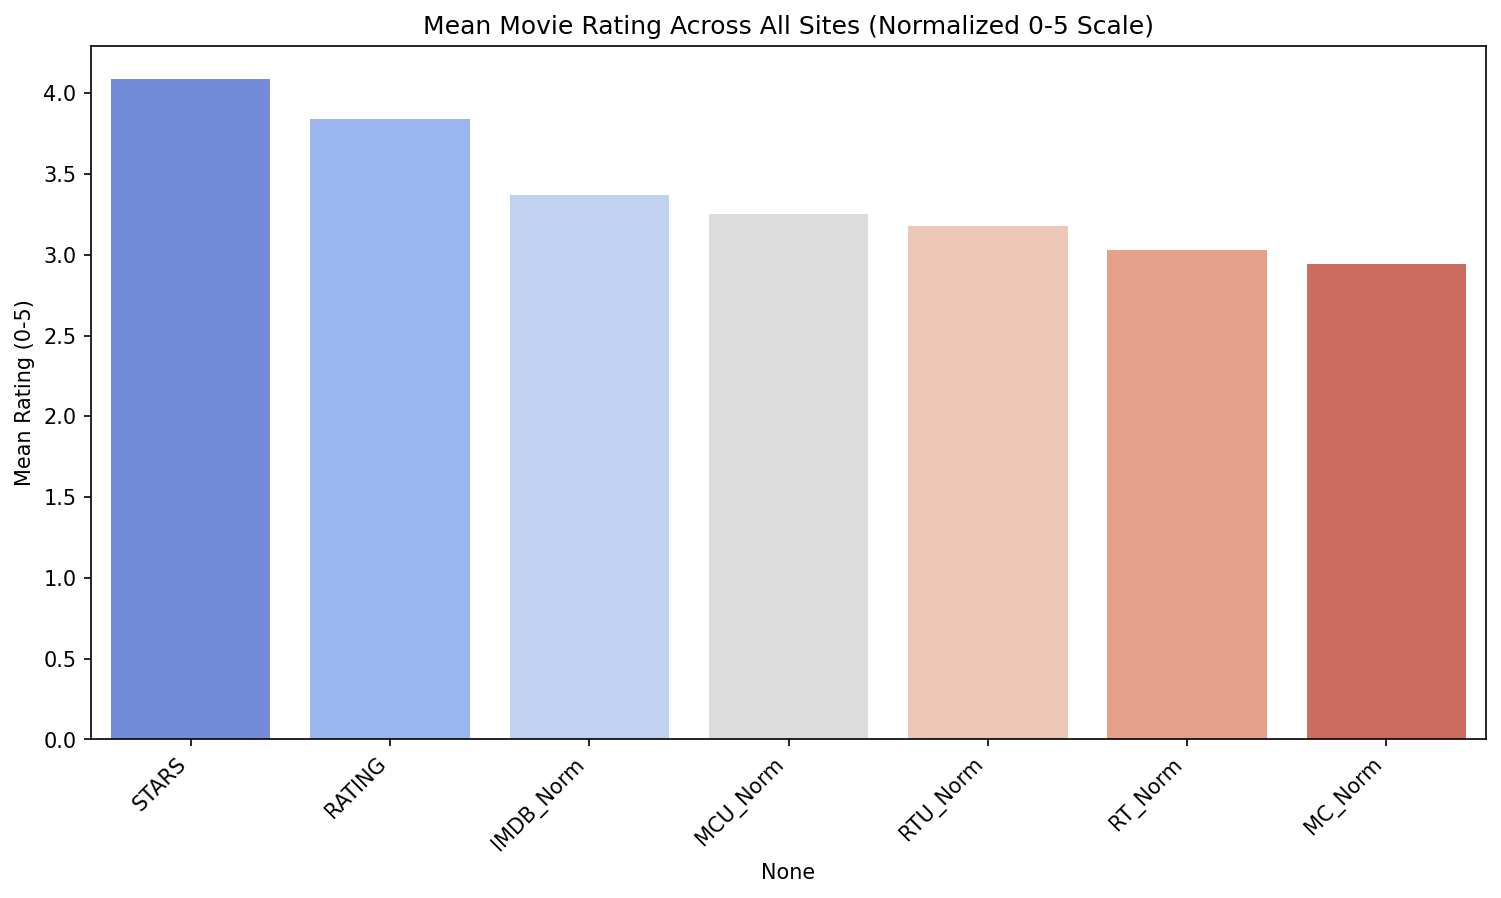

In [37]:
plt.figure(figsize=(12,6), dpi=150)
sns.barplot(x=avg_ratings.index, y=avg_ratings.values, palette='coolwarm')
plt.title('Mean Movie Rating Across All Sites (Normalized 0-5 Scale)')
plt.ylabel('Mean Rating (0-5)')
plt.xticks(rotation=45, ha='right')
plt.show()

Finally, let's visualize the distribution of all normalized scores in a single KDE plot. This provides a comprehensive view of how Fandango's distributions compare in shape and location (mean) to the distributions of scores from other major sites.

The result visually confirms the systematic inflation of Fandango ratings relative to all other sources.

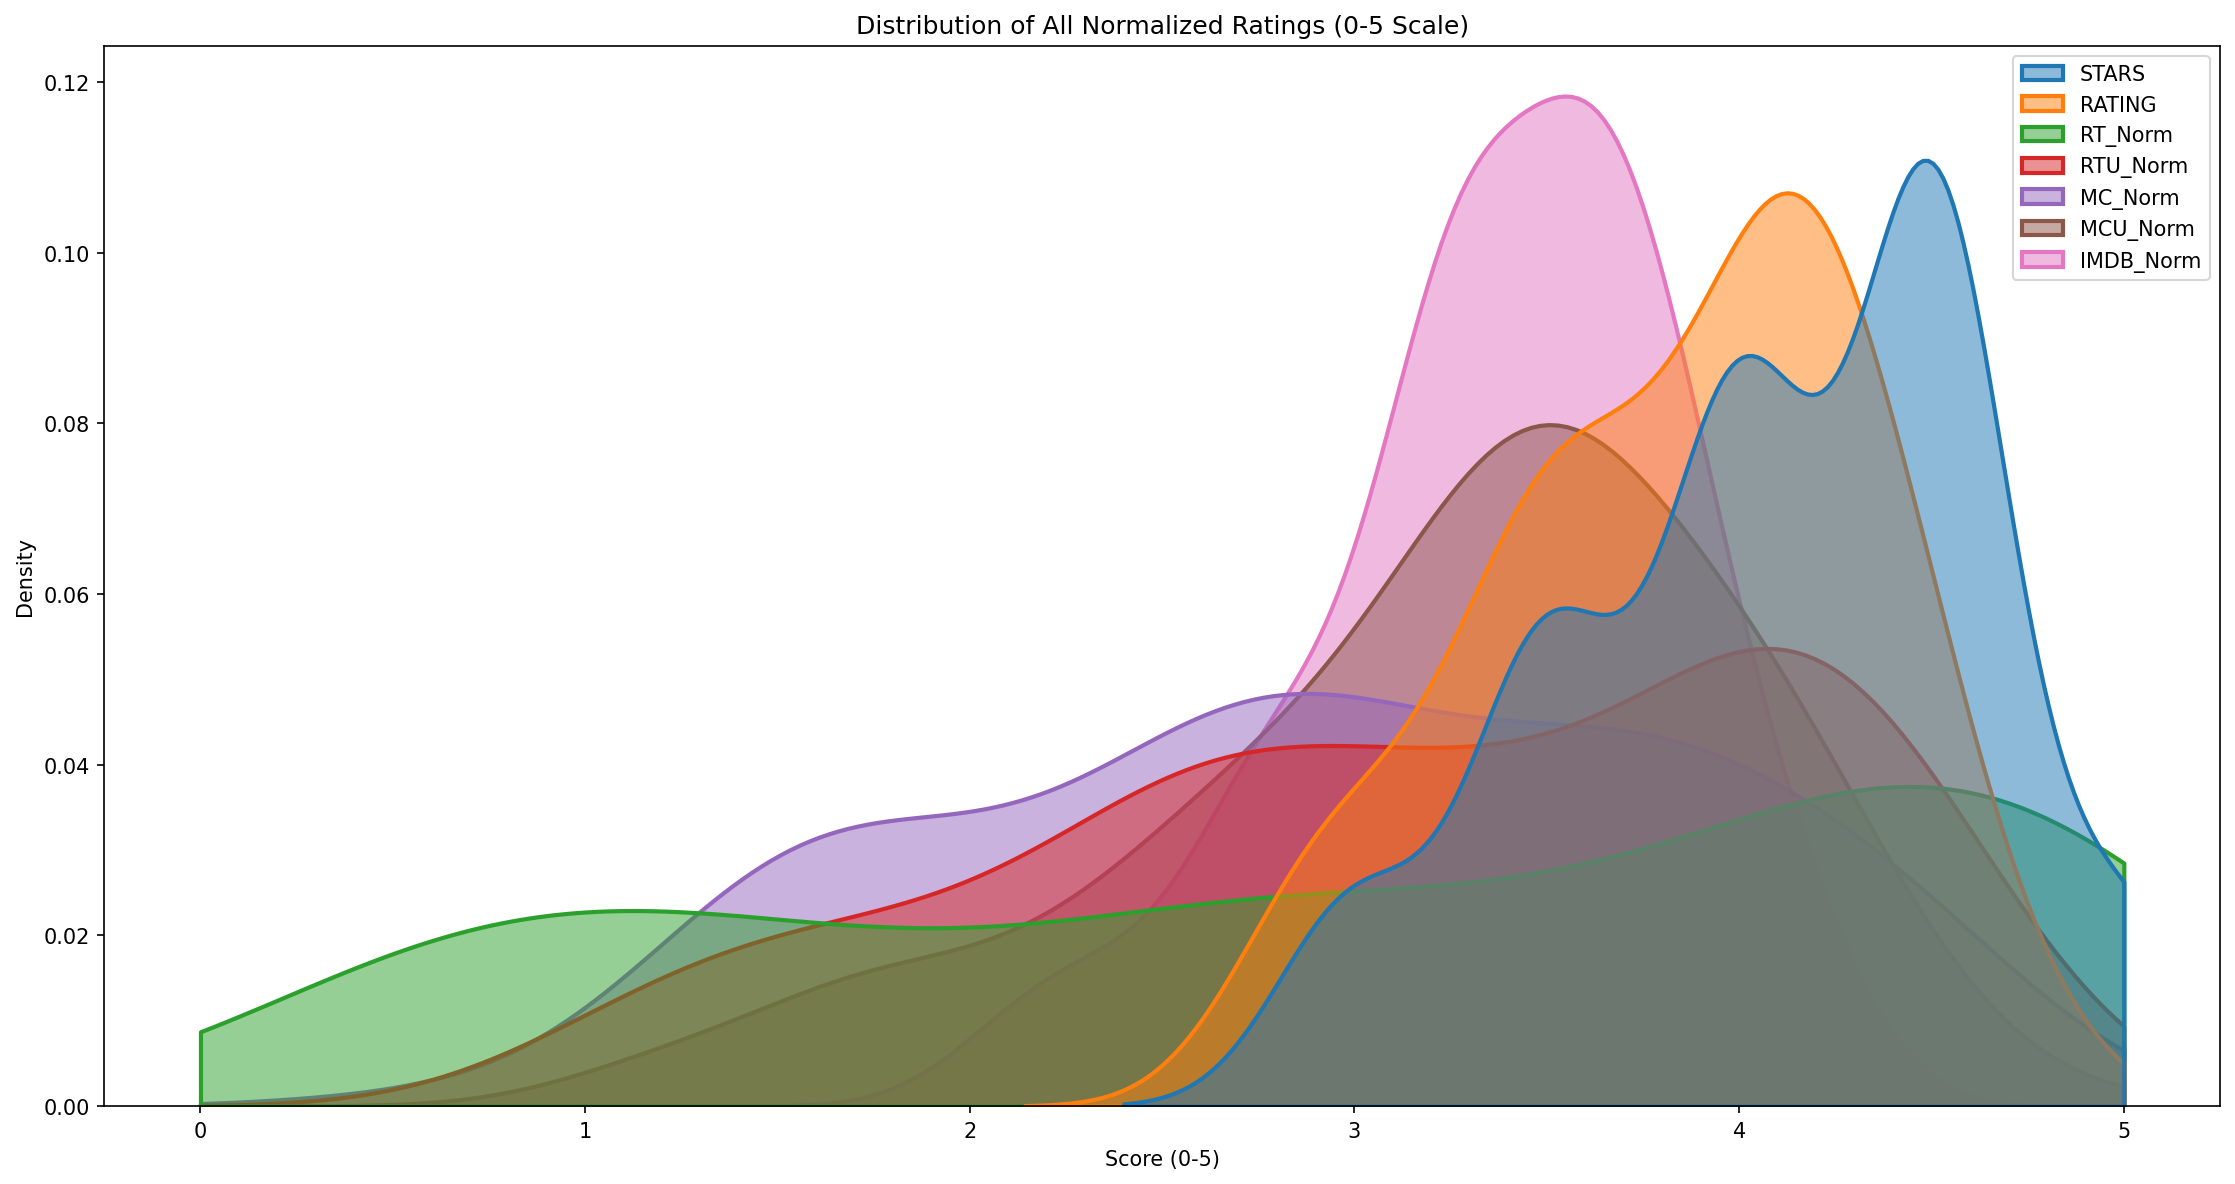

In [49]:
# # Melt the DataFrame for easy plotting of all distributions
norm_scores = all[['STARS', 'RATING', 'RT_Norm', 'RTU_Norm', 'MC_Norm', 'MCU_Norm', 'IMDB_Norm']].copy()

plt.figure(figsize=(15,8), dpi=150)
sns.kdeplot(data=norm_scores,fill=True, clip=[0,5], alpha=0.5, linewidth=2)
plt.title('Distribution of All Normalized Ratings (0-5 Scale)')
plt.xlabel('Score (0-5)')
plt.tight_layout()
plt.show()

## Conclusion

Based on the analysis, the following conclusions can be drawn:

1.  **Fandango Inflation Confirmed:** The Fandango **Displayed STARS** are systematically higher than the Fandango **Actual RATING**, with the most common difference being **0.5 stars**. On average, the displayed stars are **0.47** higher than the true rating.
2.  **Highest Mean Rating:** Fandango scores (both STARS and RATING) have the highest average among all platforms, even when normalized to the same 0-5 scale.
3.  **Distribution Bias:** The Fandango distributions are heavily skewed toward the higher end of the scale (4.0-5.0), whereas critic scores (Metacritic and Rotten Tomatoes) show a much more critical and spread-out distribution.

This analysis validates the findings of earlier reports: Fandango's rating system presents a significantly **inflated view** of a movie's popularity and quality compared to other major review sites.